In [22]:
import numpy as np
import pandas as pd

#Importing tensorflow and keras for image classification
import tensorflow as tf
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

#Importing sklearns confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [23]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
batch_size = 64

In [25]:
# Rescale normalizes the RGB pixels from [0-255] to [0-1].
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

# Using flow_from_directory to split the TB images into train, test and validation sets
train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle = False,
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                            )

Found 5440 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [26]:
#Using CNN architecture's Inception-v3 to build the image recognition model.
InceptionV3_model = tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3),weights = 'imagenet')
#Flattening the output of the last inception model layer and creating fully connected layers 
trainedV3_model = Model(InceptionV3_model.input,Flatten()(InceptionV3_model.layers[-1].output))
#Using sequential model to create stack of layers
model = Sequential([
                    trainedV3_model,
                    Dense(units=128, activation="relu"),Dropout(0.2),
                    Dense(units=1, activation="sigmoid")
                  ])
#Using binary_crossentropy and RMSprop to build the model
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 51200)             21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 28,356,641
Trainable params: 28,322,209
Non-trainable params: 34,432
_________________________________________________________________


In [27]:
#Training the model, 
epochs = 5
#Freezing the weights of pre-trained InceptionV3 model. 
trainedV3_model.trainable = False
history = model.fit(train_it,validation_data=val_it,epochs=epochs)
model.save('/content/drive/MyDrive/InceptionV3_final_opt.h5')

Epoch 1/5
85/85 [==============================] - 141s 2s/step - loss: 0.6598 - accuracy: 0.8293 - val_loss: 0.2709 - val_accuracy: 0.9206
Epoch 2/5
85/85 [==============================] - 128s 2s/step - loss: 0.0432 - accuracy: 0.9854 - val_loss: 0.1558 - val_accuracy: 0.9779
Epoch 3/5
85/85 [==============================] - 129s 2s/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.0303 - val_accuracy: 0.9949
Epoch 4/5
85/85 [==============================] - 128s 2s/step - loss: 0.0262 - accuracy: 0.9935 - val_loss: 0.0745 - val_accuracy: 0.9941
Epoch 5/5
85/85 [==============================] - 129s 2s/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 0.0813 - val_accuracy: 0.9941


In [28]:
results = model.evaluate(val_it)

22/22 [==============================] - 24s 1s/step - loss: 0.0801 - accuracy: 0.9926


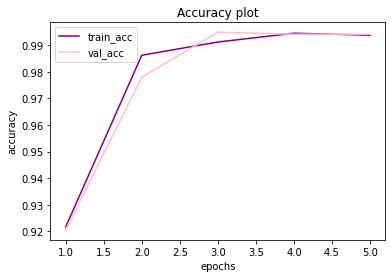

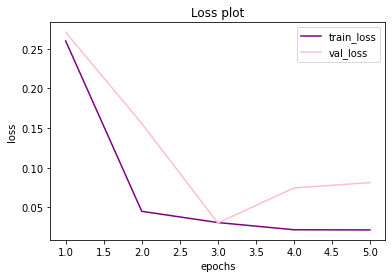

In [29]:
#Plotting the results
import matplotlib.pyplot as plt
%matplotlib inline
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [30]:
prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

22/22 - 23s


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [31]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

0.9941176470588236
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       680
           1       0.99      1.00      0.99       680

    accuracy                           0.99      1360
   macro avg       0.99      0.99      0.99      1360
weighted avg       0.99      0.99      0.99      1360



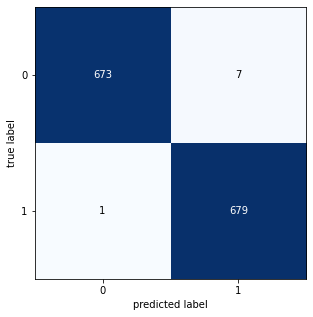

In [32]:
#Creating the confusion matrix for val images
cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

In [33]:
results = model.evaluate(test_it)

4/4 [==============================] - 45s 15s/step - loss: 5.7971e-08 - accuracy: 1.0000


In [34]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

0.995
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



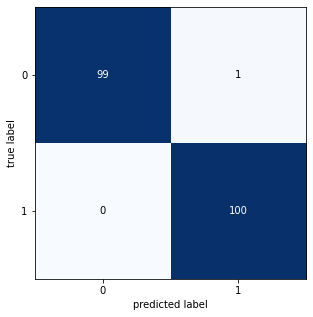

In [35]:
#Creating the confusion matrix for test images
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))